Import dei moduli

In [ ]:
import warnings
from keras.models import Sequential
from keras.layers import Dense
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers, optimizers, callbacks
from keras.callbacks import TensorBoard
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import mean_squared_error

Definizione dell'autoencoder

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)


def create_autoencoder(input_dim, l_rate, name='autoencoder'):
    # Create model
    autoencoder = Sequential(name=name)

    # Encoder
    autoencoder.add(Dense(5, input_dim=input_dim, activation='sigmoid'))

    # Internal layer
    autoencoder.add(Dense(3, activation='linear'))

    # Decoder
    autoencoder.add(Dense(5, activation='sigmoid'))

    # Output layer
    autoencoder.add(Dense(input_dim, activation='linear'))

    # Compile model
    autoencoder.compile(loss='mean_squared_error',
                        optimizer=tf.keras.optimizers.Adam(learning_rate = l_rate))

    return autoencoder

def get_output(data):
    new_model = tf.keras.Model(inputs=autoencoder_model.input, outputs=autoencoder_model.output, verbose = 0)
    output_layer = new_model.predict(data)
    return output_layer

Caricamento del Dataset

In [ ]:
Dataset = np.loadtxt("Heterogeneous_1000_1.txt", skiprows=1, delimiter=",")

Addestramento dell'autoencoder

In [ ]:
n_features = Dataset.shape[1]

l_rate = 5e-3

autoencoder_model = create_autoencoder(n_features, l_rate)

autoencoder_model.summary()

history_dict = {}

# TensorBoard Callback
cb = TensorBoard()

history_callback = autoencoder_model.fit(Dataset, Dataset,
                              batch_size=4,
                              epochs=50,
                              verbose=1,
                              callbacks=[cb])

#mse_autoencoder = history_callback.history['mean_squared_error'][-1]

score = autoencoder_model.evaluate(Dataset, Dataset, verbose=0)

print(history_callback)
history_dict[autoencoder_model.name] = [history_callback, autoencoder_model]

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 140       
                                                                 
 dense_1 (Dense)             (None, 3)                 18        
                                                                 
 dense_2 (Dense)             (None, 5)                 20        
                                                                 
 dense_3 (Dense)             (None, 27)                162       
                                                                 
Total params: 340
Trainable params: 340
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
250/250 [==============================] - 3s 4ms/step - loss: 2.6182
Epoch 2/50
250/250 [==============================] - 2s 8ms/step - loss: 1.0432
Epoch 3/50
250/250 [=======

Text(0.5, 0, 'epochs')

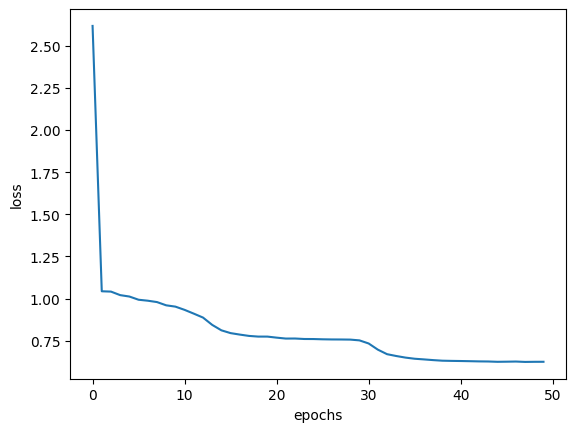

In [ ]:
loss = history_dict[autoencoder_model.name][0].history['loss']
plt.plot(loss, label= autoencoder_model.name + " loss")
plt.ylabel('loss')
plt.xlabel('epochs')

Procedura di selezione degli item

In [ ]:
#creo un vettore che va da 0 al numero di variabili
variables_range = range(0,n_features)

#produco una copia del dataset da cui andrò ad annullare le variabili
Dataset_to_drop = np.copy(Dataset)

#creo due liste che conterranno le variabili e gli errori di ricostruzione per ogni step della procedura
ann_var = []
min_MSE = []
#inizializzo il primo loop che scorre su tutte le variabili. Questi sono gli step della procedura.
for variable in variables_range:

    MSE_Scores = [] #inizializzo una lista che conterrà gli errori per ogni variabile annullata ad ogni SINGOLO step

    for iteration in variables_range: # loop per iterare su tutte le variabili AD OGNI STEP

        mult_vector = np.ones(Dataset_to_drop.shape[1]) #definisco un vettore di 1 con tanti elementi quante sono le mie variabili

        #se nella specifica iterazione il valore è ancora diverso da 0 (cioè non è stato già annullato nelle iterazioni precedenti)
        if np.any(Dataset_to_drop[:, iteration] != 0):

          np.put(mult_vector, [iteration], [0]) #lo pongo pari a 0 nel vettore che ho creato per aiutarmi

        #ora posso moltiplicare il vettore alla matrice. in questo modo tutta la colonna della variabile sarà 0
          X_Ann_Var = Dataset_to_drop*mult_vector

        #passo alla rete nete neurale il dataset con la variabile annullata e ottengo in output la ricostruzione della long-form
          reconstructed_array = get_output(X_Ann_Var)

        #arrotondo l'output per avere numeri interi
          rounded_array = np.rint(reconstructed_array)

        #calcolo l'errore di ricostruzione
          MSE = mean_squared_error(Dataset, rounded_array, squared = False)

         #conservo l'errore di ricostruzione nella lista  creata nel loop
          MSE_Scores.append(MSE)

        # se invece la variabile è già stata annullata, inserirò al posto dell'errore un numero fittizio molto alto, es. 999
        else:
          MSE_Scores.append(999)

    #a questo punto trasformo la lista di MSE in un array numpy per recuperare
    #l'indice del suo minimo e contestualmente il numero dell'item a questo associato
    MSE_Scores = np.array(MSE_Scores)

    #aggiungo 1 per recuperare il numero preciso del mio item annullato perchè gli indici partono da 0
    ann_var.append (np.argmin(MSE_Scores) + 1)
    #a questo punto annullo ufficialmente la variabile nel mio dataset e ripeto tutto per le variabili rimanenti
    #passando all'iterazione successiva
    Dataset_to_drop[:, (np.argmin(MSE_Scores))] = 0

    #conservo il minimo MSE di questa iterazione per controllare come varia l'errore tra le diverse iterazioni
    min_MSE.append(np.amin(MSE_Scores))


32/32 [==============================] - 0s 2ms/step


In [ ]:
ann_var

[9,
 27,
 8,
 16,
 7,
 17,
 25,
 26,
 18,
 14,
 22,
 11,
 13,
 5,
 12,
 23,
 21,
 3,
 2,
 4,
 24,
 19,
 20,
 15,
 1,
 6,
 10]